# Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import squarify
import spacy
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Dowanload and load catalan stopwords from `spacy`.

In [2]:
!python -m spacy download ca_core_news_sm
nlp = spacy.load("ca_core_news_sm")
stopwords = nlp.Defaults.stop_words
print(stopwords)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 9.8 MB/s eta 0:00:0010.1 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
{'unes', 'en', 'ací', "d'unes", 'heu', 'iguals', 'ús', 'quan', 'encara', 'meves', 'com', 'llarg', 'meus', 'ser', 'altra', 'jo', 'molta', 'malgrat', 'aleshores', 'des', 'estic', 'has', 'altre', "n'hi", 'quines', 'sou', 'estàvem', 'tene', 'ni', 'me', 'algun', 'nostre', 'pel', 'sons', 'es', 'contra', 'fins', 'bé', 'cadascuns', 'dels', 'donat', 'molts', 'tenim', 'ja', 'perquè', 'tenir', 'érem', 'propi', 'veu', 'éssent', "n'he", 'saps', 'pas', 'està', 'vosaltres', 'ens', 'solament', 'del', 'o', 'aquest', 'què', 'aquell', 'dintre', 'conseguim', "s'han", 'aquí', 'aquestes', 'nostra', 'tots', 'fer', 'consigueixen', 'igual', 'de', 'van', 'no', 'a', 'saber', 'cadascú', 'teves', 'quin', 'poc', 'tons', 'vostre', 'quant', 'als', 'fas', 'és', 'sa', 'elles', 'aquella', 'semblants', 'així', 'aquelles',

# Load and process csv data

In [3]:
data = pd.read_csv('../data/train.csv')

In [4]:
texts = data['text']
labels = data['class']
year = data['year']

In [11]:
type(labels)

pandas.core.series.Series

## Remove stopwords + leading and trailing quotes

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

preprocessed_texts = []
for sentence in texts:
    preprocessed_texts.append(preprocess_text(sentence))

In [16]:
print(np.random.choice(preprocessed_texts, 15, replace=False))

['caducitat inscripcions padronals ciutadans estrangers comunitaris autoritzaci residncia permanent'
 'baixes dofici padr municipal dhabitants'
 'nomenament dues tcniques dadministraci especial adscrites intervenci funcionries carrera'
 'aprovaci compte general lexercici'
 'notificaci imposici duna multa coercitiva reiteraci duna ordre restituci legalitat'
 'compte general pressupost' 'aprovaci inicial pressupost general'
 'aprovaci definitiva projecte dexecuci mesures contingudes lestudi davaluaci mobilitat generada parc valls terrassa'
 'aprovaci inicial projecte sl urbanitzable construcci dexplotaci ramadera emplaada finca masnou'
 'aprovaci definitiva pressupost general lany'
 'notificaci laprovaci provisional projecte divisi poligonal compte liquidaci polgons sector pla parcial can vernedesca nauleda sector b'
 'aprovaci definitiva modificaci pressupost'
 'aprovaci provisional segona revisi ordenances fiscals lexercici'
 'aprovaci loferta pblica docupaci lexercici'
 'bases procs s

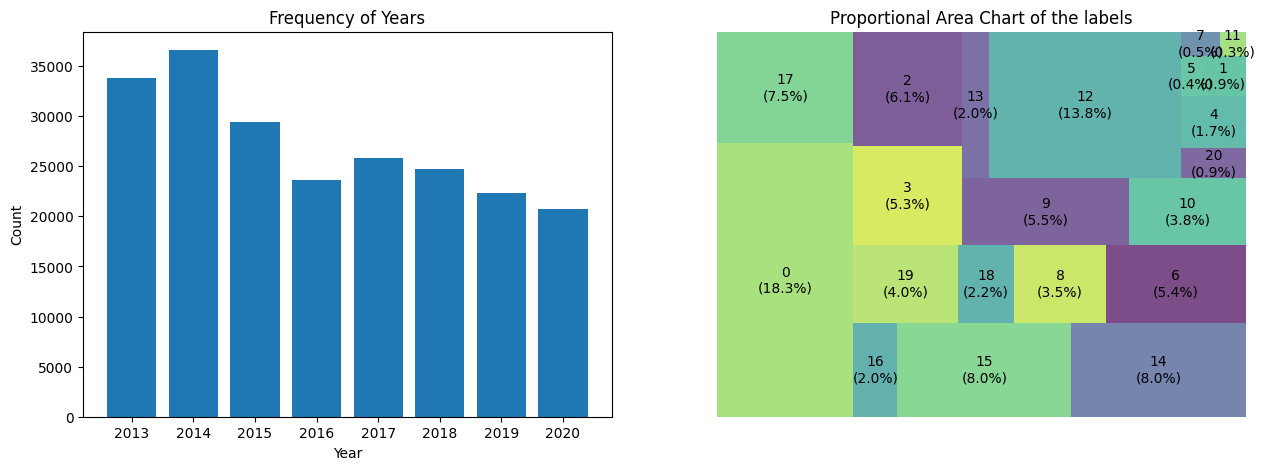

In [9]:
year_counts = Counter(year)
sorted_years = sorted(year_counts)
frequencies_years = [year_counts[year] for year in sorted_years]

lable_counts = Counter(labels)
sorted_lables = sorted(lable_counts)
frequencies_labels = [lable_counts[label] for label in sorted_lables]
labels_with_pct = [f"{label}\n({size/sum(frequencies_labels):.1%})" for label, size in lable_counts.items()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(sorted_years, frequencies_years)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Frequency of Years')


squarify.plot(sizes=lable_counts.values(), label=labels_with_pct, alpha=0.7, ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Proportional Area Chart of the labels")

# ax[1].bar(sorted_lables, frequencies_labels)
# ax[1].set_xlabel('Label')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Label Frequencies')

plt.show()

## Convert texts to TF-IDF vectors

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)

### How many unique words are in texts?

In [28]:
test_vectorizer = TfidfVectorizer()
test_vectorizer.fit(preprocessed_texts)
print(f"Total unique words in corpus: {len(test_vectorizer.vocabulary_)}")

Total unique words in corpus: 26735


In [ ]:
X = vectorizer.fit_transform(preprocessed_texts).toarray()
y = np.array(labels)

## Create a PyTorch dataset

In [6]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [ ]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TextDataset(X_test, y_test), batch_size=32)

# Basic NN

## Model Class

In [28]:
# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Initialize Model, Loss and Optimizer

In [29]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

## Training and Testing

In [7]:
def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

## History plot

In [8]:
def plot_history(n_epochs, history):
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("Training Loss and Accuracy")

    # Accuracy plot
    ax1.plot(np.arange(n_epochs), history["train_accuracy"], label="train")
    ax1.plot(np.arange(n_epochs), history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(loc="lower right")

    # Loss plot
    ax2.plot(np.arange(n_epochs), history["train_loss"],     label="train")
    ax2.plot(np.arange(n_epochs), history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.show()

## Fitting function

In [9]:
def fit(model, train_loader, test_loader, optimizer, epochs):
    history = {k: [] for k in ["train_loss", "train_accuracy", "val_loss", "val_accuracy"]}

    for epoch in range(epochs):
        train(model, train_loader, optimizer, history)
        test(model,  test_loader,  history)

        print(f"Epoch {epoch+1:02d}/{epochs} │ "
              f"loss={history['train_loss'][-1]:.4f}  "
              f"val_loss={history['val_loss'][-1]:.4f}  "
              f"acc={history['train_accuracy'][-1]:.2f}%  "
              f"val_acc={history['val_accuracy'][-1]:.2f}%")

    plot_history(epochs, history)
    return history

## Run model

Epoch 01/20 │ loss=0.2920  val_loss=0.1798  acc=91.95%  val_acc=94.55%
Epoch 02/20 │ loss=0.1623  val_loss=0.1701  acc=94.98%  val_acc=94.82%
Epoch 03/20 │ loss=0.1423  val_loss=0.1636  acc=95.48%  val_acc=95.14%
Epoch 04/20 │ loss=0.1262  val_loss=0.1626  acc=95.97%  val_acc=95.16%
Epoch 05/20 │ loss=0.1118  val_loss=0.1640  acc=96.39%  val_acc=95.27%
Epoch 06/20 │ loss=0.0992  val_loss=0.1654  acc=96.73%  val_acc=95.25%
Epoch 07/20 │ loss=0.0876  val_loss=0.1688  acc=97.13%  val_acc=95.28%
Epoch 08/20 │ loss=0.0774  val_loss=0.1731  acc=97.42%  val_acc=95.25%
Epoch 09/20 │ loss=0.0683  val_loss=0.1773  acc=97.72%  val_acc=95.29%
Epoch 10/20 │ loss=0.0605  val_loss=0.1852  acc=97.98%  val_acc=95.34%
Epoch 11/20 │ loss=0.0541  val_loss=0.1903  acc=98.19%  val_acc=95.33%
Epoch 12/20 │ loss=0.0485  val_loss=0.2000  acc=98.36%  val_acc=95.27%
Epoch 13/20 │ loss=0.0445  val_loss=0.2050  acc=98.47%  val_acc=95.21%
Epoch 14/20 │ loss=0.0404  val_loss=0.2159  acc=98.60%  val_acc=95.22%
Epoch 

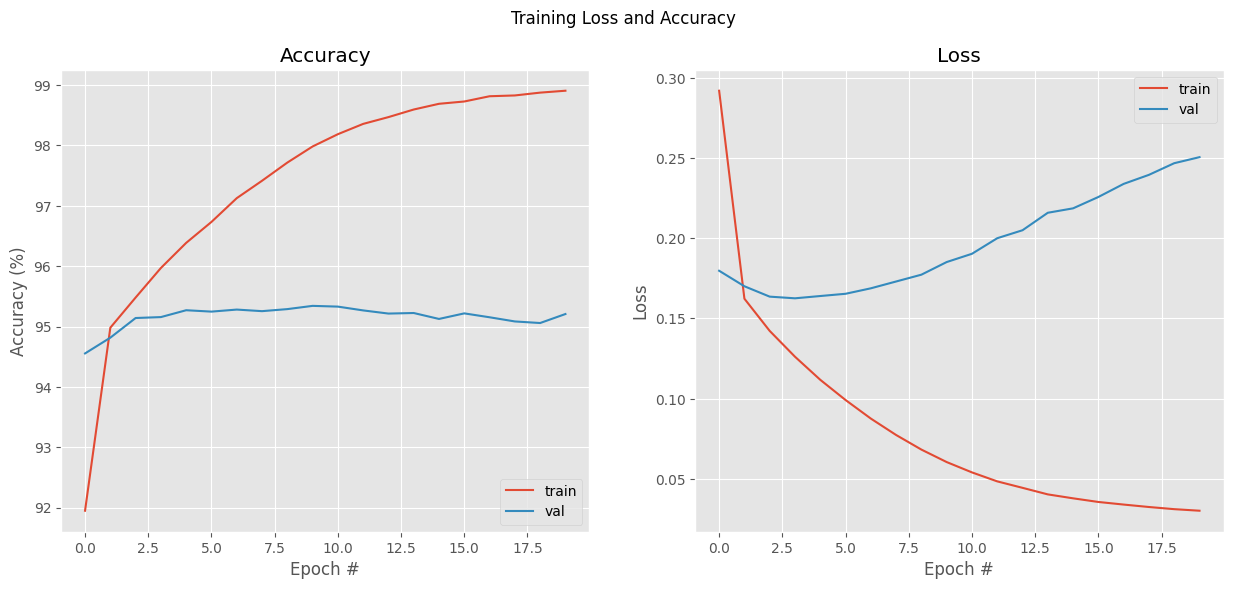

In [31]:
history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

There are clear overfitting issues with this model.

# Transformer model

In [24]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate

Hugging face BERT-like models expects tokenized inputs (This is done by lazy-tokenization):

In [34]:
df = pd.DataFrame({
    "text": preprocessed_texts,
    "label": labels
})

train_tok, test_tok = train_test_split(df, test_size=0.25,
                                       stratify=labels, random_state=0)

train_tok = Dataset.from_pandas(train_tok)
test_tok   = Dataset.from_pandas(test_tok)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True
                     )

# Convert to HuggingFace Dataset object to be able to use .map()
# train_dataset = Dataset.from_dict({"text": X_train_tok, "label": y_train_tok})
# test_dataset  = Dataset.from_dict({"text": X_test_tok,  "label": y_test_tok})
train_tok = train_tok.map(tokenize)
test_tok  = test_tok.map(tokenize)

train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 54244/54244 [00:10<00:00, 5329.54 examples/s]


APUNTAR EN EL PPT QUÈ MERDES ÉS EL BERT-BASE-UNCASED:

- **BERT** stands for **Bidirectional Encoder Representations from Transformers**.

- It’s a pretrained Transformer-based model developed by Google in 2018.

- Designed to understand language **bidirectionally** (looking at context from both left and right).

- `"base"` means it’s the smaller version of BERT (compared to `bert-large`).

- `"uncased"` means it does not distinguish uppercase and lowercase letters — input text is lowercased before tokenization.


When to Use:
- Great general-purpose language model.

- Lowercased text input, so works best on texts that are not case-sensitive.

- Efficient enough for many applications while maintaining strong performance.

Model Specs:

| Feature                | Description                 |
|------------------------|-----------------------------|
| Layers (Transformer blocks) | 12                      |
| Hidden size            | 768                         |
| Attention heads        | 12                          |
| Parameters             | ~110 million                |
| Vocabulary size        | 30,522 tokens               |
| Max input length       | 512 tokens                  |

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=21,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer wrapping (so it can be used as a sklearn-like model)

In [38]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

args = TrainingArguments(
    output_dir=".outputs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    num_train_epochs=2,           # 2-3 epochs usually fine when fine-tuning
    fp16=True,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Run model

In [39]:
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.211900,0.201387,0.954742
2,0.147700,0.162076,0.963093


{'eval_loss': 0.16207608580589294,
 'eval_accuracy': 0.9630926922793305,
 'eval_runtime': 136.7285,
 'eval_samples_per_second': 396.728,
 'eval_steps_per_second': 49.595,
 'epoch': 2.0}

FINAL NOTES: since the transformer model DOES NOT perform better than the FCNN, we will modify the FCNN in order to reduce the overfitting issue. We will also try training using per-year data and see its performance when predicting the following year data.

# FCNN: Dealing with overfitting

## Adding Dropout layer and Batch Normalization

`Dropout` randomly disables some neurons during training, forcing the model to generalize better whereas `Batch Normalization` helps in stabilizing and regularizing the training, especially in deeper networks.

In [10]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)

        return out

Epoch 01/20 │ loss=0.3481  val_loss=0.1881  acc=90.51%  val_acc=94.48%
Epoch 02/20 │ loss=0.2386  val_loss=0.1750  acc=93.16%  val_acc=94.79%
Epoch 03/20 │ loss=0.2168  val_loss=0.1695  acc=93.65%  val_acc=94.91%
Epoch 04/20 │ loss=0.1992  val_loss=0.1651  acc=94.18%  val_acc=95.15%
Epoch 05/20 │ loss=0.1903  val_loss=0.1635  acc=94.39%  val_acc=95.18%
Epoch 06/20 │ loss=0.1813  val_loss=0.1620  acc=94.54%  val_acc=95.22%
Epoch 07/20 │ loss=0.1715  val_loss=0.1665  acc=94.78%  val_acc=95.02%
Epoch 08/20 │ loss=0.1686  val_loss=0.1628  acc=94.88%  val_acc=95.30%
Epoch 09/20 │ loss=0.1620  val_loss=0.1609  acc=95.06%  val_acc=95.35%
Epoch 10/20 │ loss=0.1570  val_loss=0.1609  acc=95.16%  val_acc=95.34%
Epoch 11/20 │ loss=0.1528  val_loss=0.1630  acc=95.31%  val_acc=95.26%
Epoch 12/20 │ loss=0.1496  val_loss=0.1597  acc=95.31%  val_acc=95.40%
Epoch 13/20 │ loss=0.1464  val_loss=0.1623  acc=95.45%  val_acc=95.46%
Epoch 14/20 │ loss=0.1450  val_loss=0.1604  acc=95.51%  val_acc=95.48%
Epoch 

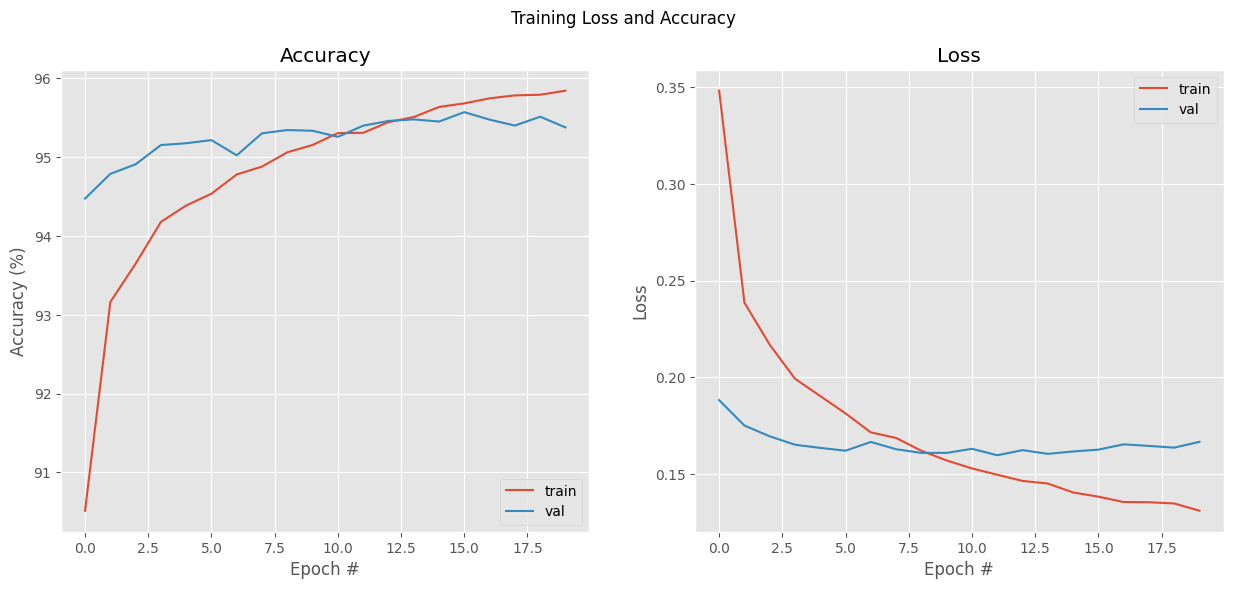

In [ ]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

We can see the overfitting has improved at the cost of reducing slightly the training accuracy of the model: 98,91 -> 95,84. 

The validation (test) accuracy improves though: 95,21 -> 95,38

## Yearly data distribution for train and testing

Now we will use data from a specific year as the validation set, and data from the previous year as the training set. This approach helps estimate the model’s predictive power on future (unseen) data, simulating how it might perform on the final test set.

Notice we define the vectorizer and the fcnn outside the loop. 1. We are fiting the vectorizer with the entire preprocess data. 2. The fcnn has its weights improved in each year.

### Define max_eatures for the vectorizer (and input_size for the FCNN) as 10000 (~30% of all the unique words in preprocessed data)

Length Traing data: 33770
Length Test data: 36589
Epoch 01/5 │ loss=0.4533  val_loss=0.2373  acc=88.18%  val_acc=93.45%
Epoch 02/5 │ loss=0.1602  val_loss=0.2621  acc=95.69%  val_acc=93.39%
Epoch 03/5 │ loss=0.1146  val_loss=0.2710  acc=96.89%  val_acc=93.44%
Epoch 04/5 │ loss=0.0890  val_loss=0.2833  acc=97.47%  val_acc=93.45%
Epoch 05/5 │ loss=0.0746  val_loss=0.2864  acc=97.85%  val_acc=93.64%


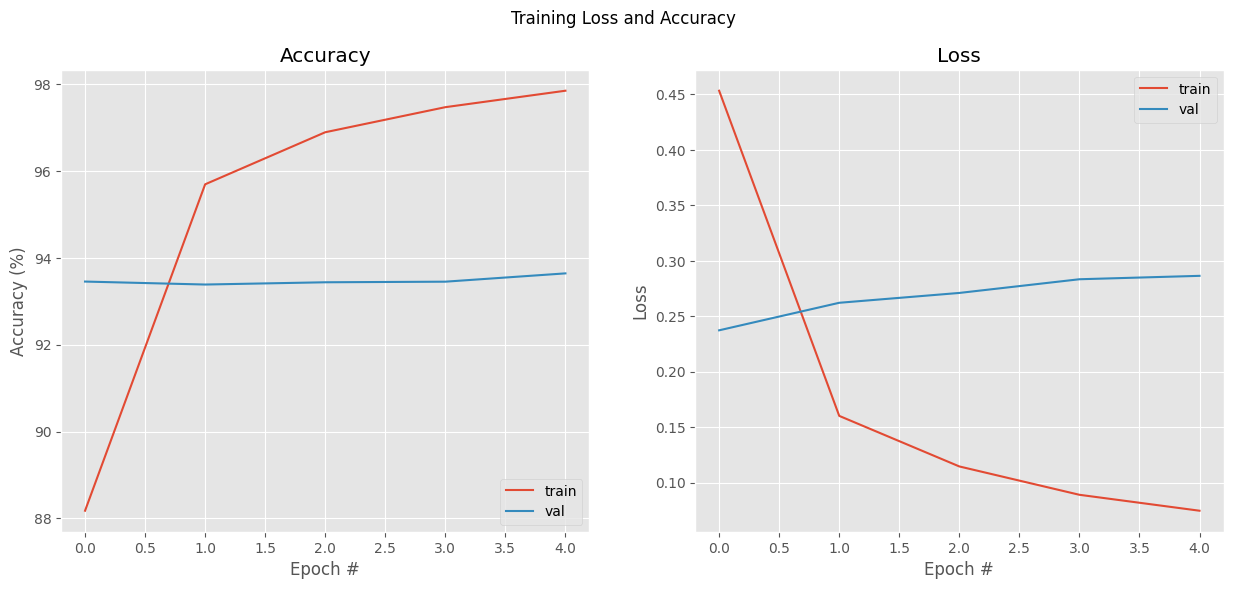

Length Traing data: 70359
Length Test data: 29412
Epoch 01/5 │ loss=0.1764  val_loss=0.2335  acc=95.08%  val_acc=93.86%
Epoch 02/5 │ loss=0.1179  val_loss=0.2162  acc=96.51%  val_acc=94.35%
Epoch 03/5 │ loss=0.1010  val_loss=0.2509  acc=97.00%  val_acc=94.02%
Epoch 04/5 │ loss=0.0894  val_loss=0.2548  acc=97.35%  val_acc=94.01%
Epoch 05/5 │ loss=0.0833  val_loss=0.2639  acc=97.50%  val_acc=94.00%


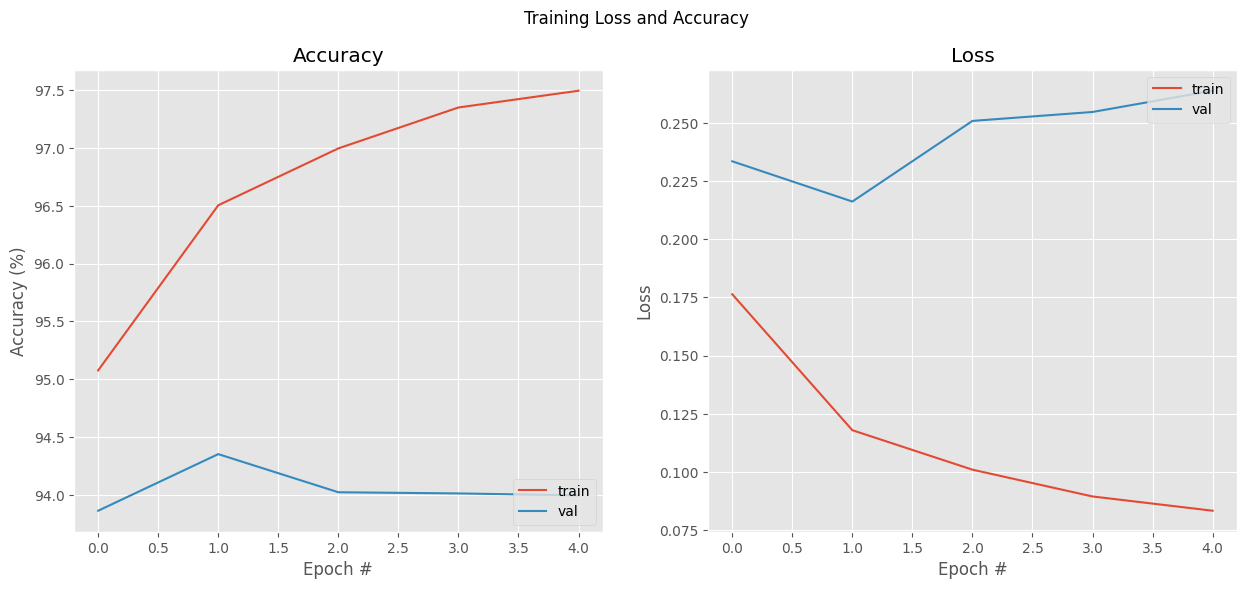

Length Traing data: 99771
Length Test data: 23589
Epoch 01/5 │ loss=0.1294  val_loss=0.2166  acc=96.36%  val_acc=94.48%
Epoch 02/5 │ loss=0.1003  val_loss=0.2148  acc=97.05%  val_acc=94.59%
Epoch 03/5 │ loss=0.0880  val_loss=0.2295  acc=97.36%  val_acc=94.68%
Epoch 04/5 │ loss=0.0825  val_loss=0.2394  acc=97.50%  val_acc=94.44%
Epoch 05/5 │ loss=0.0756  val_loss=0.2365  acc=97.73%  val_acc=94.53%


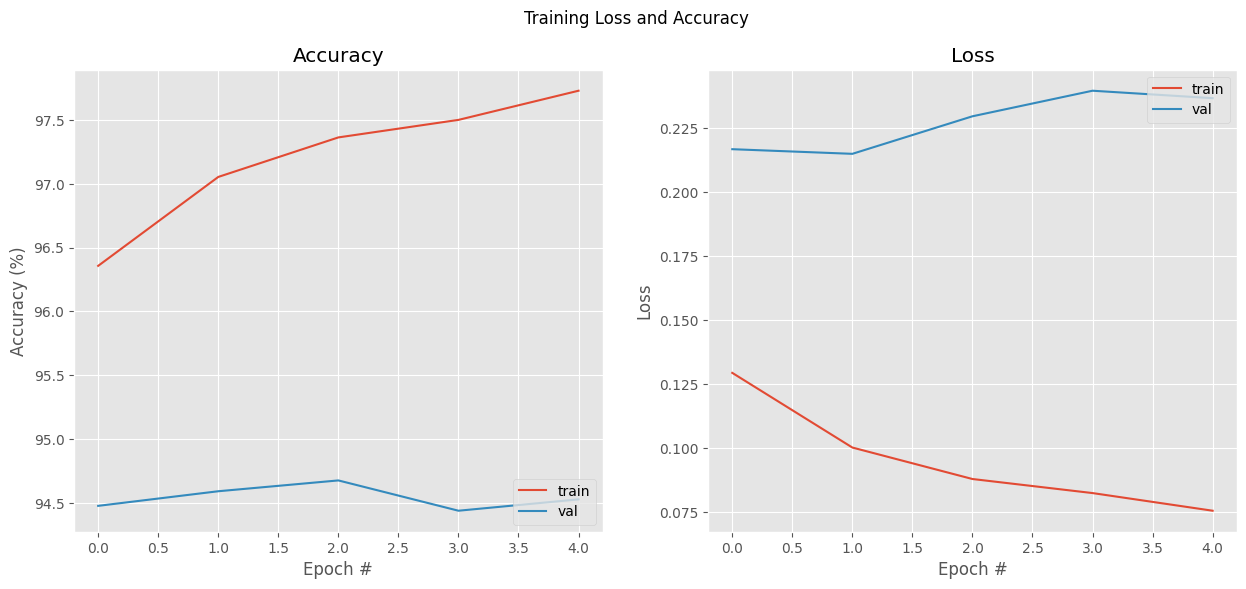

Length Traing data: 123360
Length Test data: 25813
Epoch 01/5 │ loss=0.1097  val_loss=0.1865  acc=97.01%  val_acc=95.36%
Epoch 02/5 │ loss=0.0875  val_loss=0.1846  acc=97.42%  val_acc=95.42%
Epoch 03/5 │ loss=0.0813  val_loss=0.2031  acc=97.58%  val_acc=95.07%
Epoch 04/5 │ loss=0.0755  val_loss=0.1981  acc=97.75%  val_acc=95.49%
Epoch 05/5 │ loss=0.0709  val_loss=0.2060  acc=97.88%  val_acc=95.43%


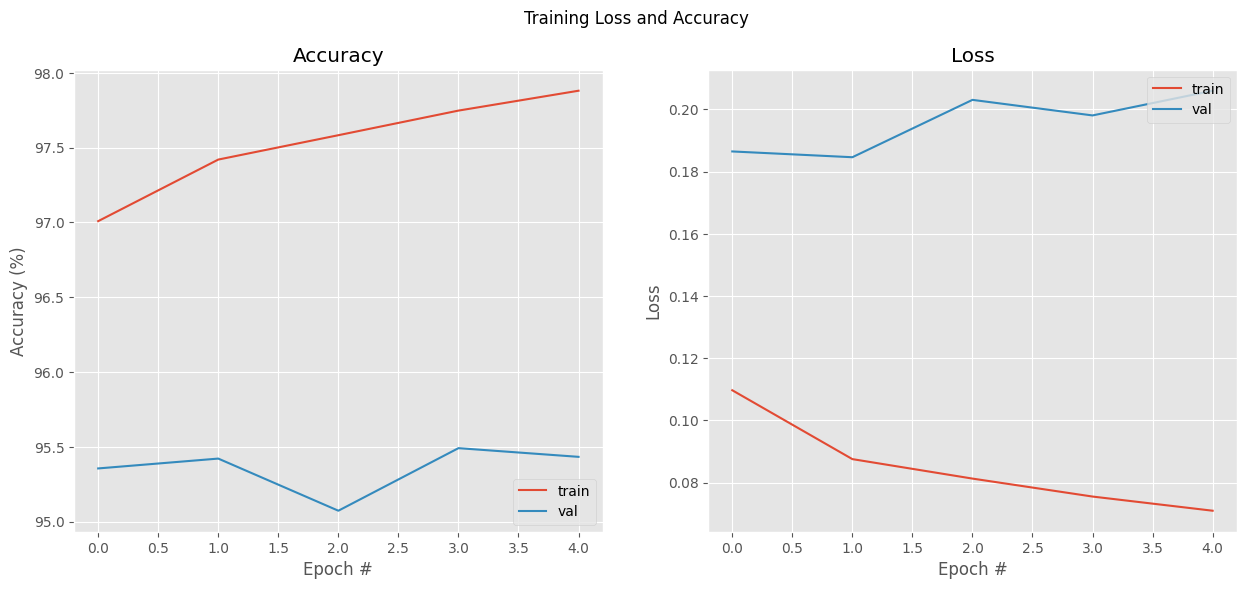

Length Traing data: 149173
Length Test data: 24734
Epoch 01/5 │ loss=0.1003  val_loss=0.2005  acc=97.24%  val_acc=94.88%
Epoch 02/5 │ loss=0.0853  val_loss=0.1888  acc=97.54%  val_acc=95.26%
Epoch 03/5 │ loss=0.0772  val_loss=0.1988  acc=97.71%  val_acc=95.20%
Epoch 04/5 │ loss=0.0713  val_loss=0.1993  acc=97.88%  val_acc=95.22%
Epoch 05/5 │ loss=0.0688  val_loss=0.2067  acc=97.93%  val_acc=95.25%


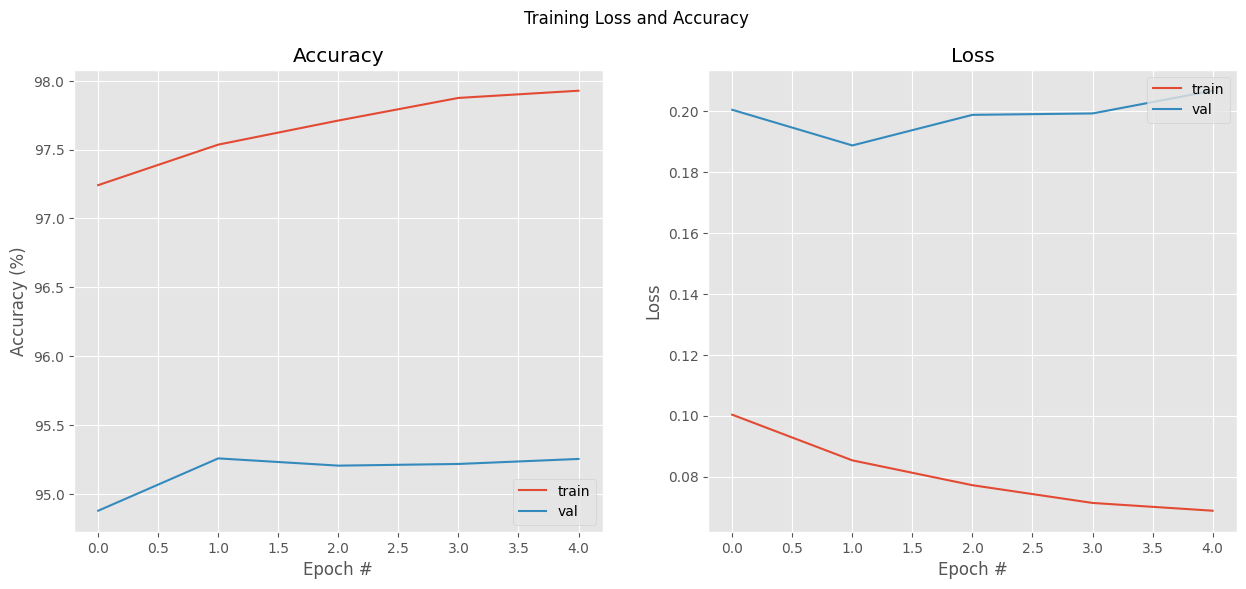

Length Traing data: 173907
Length Test data: 22365
Epoch 01/5 │ loss=0.0944  val_loss=0.1672  acc=97.36%  val_acc=95.65%
Epoch 02/5 │ loss=0.0818  val_loss=0.1751  acc=97.63%  val_acc=95.59%
Epoch 03/5 │ loss=0.0755  val_loss=0.1776  acc=97.82%  val_acc=95.69%
Epoch 04/5 │ loss=0.0709  val_loss=0.1798  acc=97.87%  val_acc=95.55%
Epoch 05/5 │ loss=0.0695  val_loss=0.1767  acc=97.95%  val_acc=95.79%


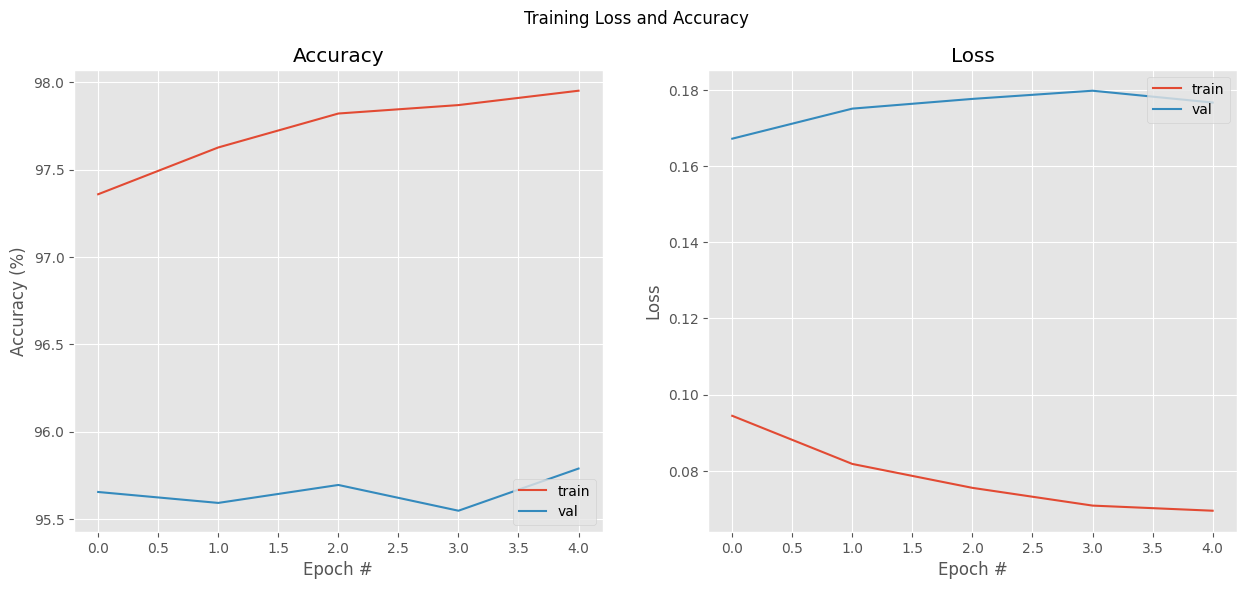

Length Traing data: 196272
Length Test data: 20702
Epoch 01/5 │ loss=0.0847  val_loss=0.2790  acc=97.64%  val_acc=94.33%
Epoch 02/5 │ loss=0.0758  val_loss=0.2840  acc=97.76%  val_acc=94.39%
Epoch 03/5 │ loss=0.0716  val_loss=0.2958  acc=97.91%  val_acc=94.30%
Epoch 04/5 │ loss=0.0688  val_loss=0.2898  acc=97.97%  val_acc=94.25%
Epoch 05/5 │ loss=0.0658  val_loss=0.3041  acc=98.03%  val_acc=94.31%


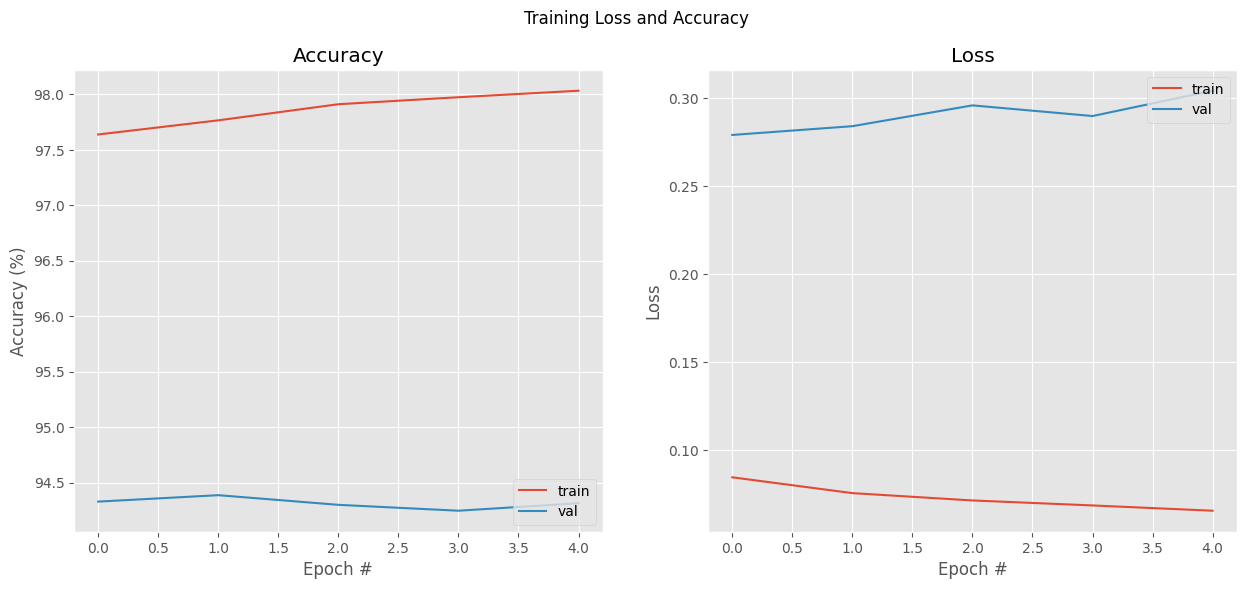

In [14]:
year_num = 2014
val_acc_history = {}

vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit(preprocessed_texts)

fcnn = FCNN(input_size=10000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

while year_num <= 2020:

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y < year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ < year_num])
    print(f'Length Traing data: {len(y)}')
    train_dataset = DataLoader(TextDataset(X, y), batch_size=32, shuffle=True)

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y == year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ == year_num])
    print(f'Length Test data: {len(y)}')    
    test_dataset = DataLoader(TextDataset(X, y), batch_size=32)

    history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 5
    )

    val_acc_history[year_num] = history['val_accuracy'][-1]

    year_num += 1

In [45]:
val_acc_history

{2014: 26.149935773046543,
 2015: 19.815041479668164,
 2016: 9.300945355886219,
 2017: 15.747878975709913,
 2018: 9.428317296029757,
 2019: 8.513302034428795,
 2020: 7.907448555695102}